###  KNN, Naive Bayes Classifier, and ROC analysis


In [1]:
import numpy as np
import pylab as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score 
from collections import Counter
from random import seed
from random import randrange
from sklearn import feature_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

#### 1.First load data and do normalization and remove constant features

In [2]:
X_train = np.loadtxt('X_train.csv', delimiter=',', skiprows=1)
X_test = np.loadtxt('X_test.csv', delimiter=',', skiprows=1)
Y_train = np.loadtxt('y_train.csv', delimiter=',', skiprows=1)[:,1][:,None]

rec_arr = np.genfromtxt("X_train.csv", delimiter = ",", names=True, dtype=None)
feature_list = []
for i in rec_arr.dtype.names:
    feature_list.append(i)
feature_list.pop(86)

feature_list = np.array(feature_list)

# Make an instance of the Model
# remove constant features
thresholder = VarianceThreshold(threshold=0)
X_train = thresholder.fit_transform(X_train)
X_test = thresholder.transform(X_test)
# normalize the data 

feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

#### 2.Write KNN classifier

In [3]:
def knn_classifier(trainX, traint, test_data, K):
    # computing distances between the testing data(one row)to all training data
    distances = np.sqrt(((trainX - test_data)**2).sum(axis=1)) 
    # zip the train data distance and the class them below to dy 
    dy = zip(distances, traint) 
    # sort the dy bt distance
    dy = sorted(dy, key = lambda x: x[0]) 
    # select K instances of neareast neighbours
    k_selected_neighbor = np.asarray(dy[:K]) 
    classes, counts = np.unique(k_selected_neighbor[:,1], return_counts=True)
    prediction = {}
    # assign the class of training data to the testing data with the highest ammount
    prediction["predicted_class"] = classes[counts.argmax()]
    # calculate the prediction score for testing data 
    if ( len(classes) == 1 and classes[counts.argmax()] == 2.0):
        prediction["predicted_score"] = np.hstack( (1.0- (1.0*counts/sum(counts)), 1.0*counts/sum(counts) ) )
    elif ( len(classes) == 1 and classes[counts.argmax()] == 1.0):
        prediction["predicted_score"] = np.hstack( ( 1.0*counts/sum(counts), 1.0- (1.0*counts/sum(counts)) ) )
    else:
        prediction["predicted_score"] = 1.0*counts/sum(counts)
    return(prediction)

#### 3.Split the training data into test and training data for cross validation with ratio 3:7

In [4]:
cross_X_train, cross_X_test, cross_Y_train, cross_Y_test = train_test_split(X_train,Y_train, test_size=0.3,random_state=28)
ctrain = Counter(cross_Y_train.flatten())
ctest =  Counter(cross_Y_test.flatten())
print(ctrain)
print(ctest)

Counter({2.0: 73, 1.0: 67})
Counter({2.0: 33, 1.0: 27})


#### 4.Training and predicting the result with different classifiers

In [5]:
cross_X_train, cross_Y_train = cross_X_train, cross_Y_train.flatten()
cross_X_test, cross_Y_test = cross_X_test, cross_Y_test.flatten()
#Create a Gaussian Classifier
model = GaussianNB()
#cross_priori, cross_stats = nb_train(cross_X_train, cross_Y_train)
#cross_y_test_pred, cross_y_test_prob = predict(cross_priori, cross_stats, cross_X_test)

model.fit(cross_X_train,cross_Y_train)
cross_y_test_pred = model.predict(cross_X_test)


cross_y_test_prob = model.predict_proba(cross_X_test)



predictions_knn = np.zeros((60, 3))
for j,tx in enumerate(cross_X_test):
    knn_results = knn_classifier(cross_X_train, cross_Y_train, tx, K = 9)
    predictions_knn[j, 0] = knn_results['predicted_class']
    predictions_knn[j, 1:] = knn_results['predicted_score']

#### 3.Sketch the ROC comparison for KNN and NB classifier on the training data splited before

Text(0, 0.5, 'Sensitivity or True Positive Rate')

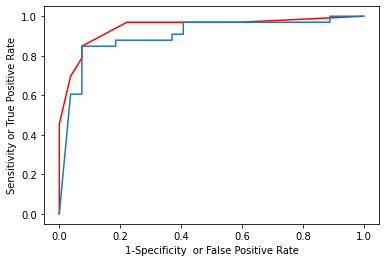

In [6]:
fpr_nb, tpr_nb, th_nb = roc_curve(cross_Y_test - 1, cross_y_test_prob[:,1])
fpr_knn, tpr_knn, th_knn = roc_curve(cross_Y_test-1, predictions_knn[:,2])
plt.plot(fpr_knn, tpr_knn, "r")
plt.plot(fpr_nb, tpr_nb)
plt.xlabel("1-Specificity  or False Positive Rate")
plt.ylabel("Sensitivity or True Positive Rate")